In [6]:

!pip install numpy pandas scikit-learn xgboost graphviz opendatasets lightgbm --quiet  #graphviz is used to visualize the xgboost


import pandas as pd
ross_df=pd.read_csv("train.csv")
test_df=pd.read_csv("test.csv")
store_df=pd.read_csv("store.csv")
#ross_df


merged_df=ross_df.merge(store_df,how="left",on="Store")
merged_test=test_df.merge(store_df,how="left",on="Store")

def split_date(df):
  df["Date"]=pd.to_datetime(df["Date"])  # here we have converted date in pandas then extracted year from this
  df["Year"]=df.Date.dt.year
  df["Month"]=df.Date.dt.month   # here we have made extra coluns of date and coverted tp readable pandas
  df["Day"]=df.Date.dt.day
  df["WeekOfYear"]=df.Date.dt.isocalendar().week


split_date(merged_df)
split_date(merged_test)

merged_df[merged_df.Open==0].Sales.value_counts()

merged_df=merged_df[merged_df.Open==1].copy()  #here we have made dataset where store is only open

def comp_months(df):
    df["CompetitionOpen"]=12*(df.Year-df.CompetitionOpenSinceYear)+(df.Month-df.CompetitionOpenSinceMonth)
    df["CompetitionOpen"]=df.CompetitionOpen.apply(lambda x:0 if x<0 else x).fillna(0) #yaha pe negative month hoge to unko zero bna diya aur na.s ko bhi 0

comp_months(merged_df)
comp_months(merged_test)


def check_promo_month(row):
  month2str={1:"Jan",2:"Feb",3:"Mar",4:"Apr",5:"May",6:"Jun",7:"Jul",8:"Aug",9:"Sep",10:"Oct",11:"Nov",12:"Dec"}
  try:
     months=(row["Promo2Interval"] or "").split(",")
     if row["Promo2OPen"] and month2str[row["Month"]] in months:
       return 1
     else:
       return 0
  except Exception:
    return 0


def promo_cols(df):
    df["Promo2Open"]=12*(df.Year-df.Promo2SinceYear)+(df.WeekOfYear-df.Promo2SinceWeek)
    df["Promo2Open"]=df.Promo2Open.apply(lambda x:0 if x<0 else x).fillna(0)
    df["IsPromoMonth"]=df.apply(check_promo_month,axis=1)


promo_cols(merged_df)
promo_cols(merged_test)

#merged_df.columns


input_cols=["Store","DayOfWeek","Promo","Day","Month","Year","Promo2","WeekOfYear","StateHoliday","SchoolHoliday","StoreType","Assortment","CompetitionDistance","CompetitionOpen","Promo2Open","IsPromoMonth"]
target_cols=["Sales"]


inputs=merged_df[input_cols].copy()
target=merged_df[target_cols].astype("float32").copy()
test_inputs=merged_test[input_cols].copy()


numeric_cols=["Store","Promo","SchoolHoliday","CompetitionDistance","CompetitionOpen","Promo2Open","IsPromoMonth","Promo2","Day","Month","Year","WeekOfYear"]
cate_cols=["StoreType","Assortment","StateHoliday","DayOfWeek"]


inputs[numeric_cols].isna().sum()    #find hoe many numeric cols have na values    #only distanve have unknown values means they have no comp distance so we fill with max values

max_distance=inputs.CompetitionDistance.max()
max_distance

inputs["CompetitionDistance"].fillna(max_distance,inplace=True)
test_inputs["CompetitionDistance"].fillna(max_distance,inplace=True)

inputs[numeric_cols].isna().sum()


from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler()
inputs[numeric_cols]=scaler.fit_transform(inputs[numeric_cols])
test_inputs[numeric_cols]=scaler.transform(test_inputs[numeric_cols])



for column in cate_cols:
    inputs[column] = inputs[column].astype(str)  # Convert to strings to ensure uniformity
    test_inputs[column] = test_inputs[column].astype(str)  # Do the same for test data


from sklearn.preprocessing import OneHotEncoder
encoder=OneHotEncoder(sparse_output=False,handle_unknown="ignore").fit(inputs[cate_cols])
encoded_cols=list(encoder.get_feature_names_out(cate_cols))
inputs[encoded_cols]=encoder.transform(inputs[cate_cols])
test_inputs[encoded_cols]=encoder.transform(test_inputs[cate_cols])

x_train=inputs[encoded_cols+numeric_cols]
x_test=test_inputs[encoded_cols+numeric_cols]

x_train


/tmp/ipython-input-6-393276039.py:5: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  ross_df=pd.read_csv("train.csv")
/tmp/ipython-input-6-393276039.py:79: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  inputs["CompetitionDistance"].fillna(max_distance,inplace=True)
/tmp/ipython-input-6-393276039.py:80: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This

,StoreType_a,StoreType_b,StoreType_c,StoreType_d,Assortment_a,Assortment_b,Assortment_c,StateHoliday_0,StateHoliday_a,StateHoliday_b,...,SchoolHoliday,CompetitionDistance,CompetitionOpen,Promo2Open,IsPromoMonth,Promo2,Day,Month,Year,WeekOfYear
0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,1.0,0.016482,0.059163,0.000000,0.0,0.0,1.000000,0.545455,1.0,0.588235
1,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,1.0,0.007252,0.066378,0.821053,0.0,1.0,1.000000,0.545455,1.0,0.588235
2,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,1.0,0.186050,0.074315,0.684211,0.0,1.0,1.000000,0.545455,1.0,0.588235
3,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,...,1.0,0.007911,0.050505,0.000000,0.0,0.0,1.000000,0.545455,1.0,0.588235
4,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,1.0,0.394119,0.002165,0.000000,0.0,0.0,1.000000,0.545455,1.0,0.588235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
504618,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.114979,0.000000,0.389474,0.0,1.0,0.133333,0.272727,0.0,0.254902
504619,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,...,0.0,0.029931,0.000000,0.042105,0.0,1.0,0.133333,0.272727,0.0,0.254902
504620,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,...,0.0,0.008703,0.075758,0.000000,0.0,0.0,0.133333,0.272727,0.0,0.254902
504621,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.148734,0.018038,0.000000,0.0,0.0,0.133333,0.272727,0.0,0.254902


(array([2.7000e+01, 4.8000e+01, 2.6400e+02, 7.6000e+02, 1.7400e+03,
        3.4610e+03, 5.8730e+03, 9.3870e+03, 1.3839e+04, 1.8453e+04,
        2.2426e+04, 2.5907e+04, 2.7935e+04, 2.8755e+04, 2.8859e+04,
        2.7010e+04, 2.4878e+04, 2.2753e+04, 2.1206e+04, 1.8639e+04,
        1.6313e+04, 1.3886e+04, 1.2390e+04, 1.0252e+04, 8.9670e+03,
        7.7750e+03, 6.5570e+03, 5.4910e+03, 4.8000e+03, 3.9270e+03,
        3.2390e+03, 2.7780e+03, 2.3540e+03, 2.0450e+03, 1.7120e+03,
        1.4630e+03, 1.2930e+03, 1.0840e+03, 9.9000e+02, 9.2000e+02,
        7.9300e+02, 6.5800e+02, 5.4100e+02, 5.3600e+02, 4.5000e+02,
        4.1400e+02, 4.0200e+02, 3.0200e+02, 2.8100e+02, 2.4100e+02,
        2.2900e+02, 1.9300e+02, 1.6400e+02, 1.2700e+02, 1.3600e+02,
        1.0600e+02, 9.5000e+01, 6.7000e+01, 5.4000e+01, 6.8000e+01,
        4.5000e+01, 3.5000e+01, 3.3000e+01, 1.9000e+01, 3.8000e+01,
        2.5000e+01, 1.8000e+01, 2.1000e+01, 2.2000e+01, 1.6000e+01,
        1.5000e+01, 1.1000e+01, 1.5000e+01, 1.10

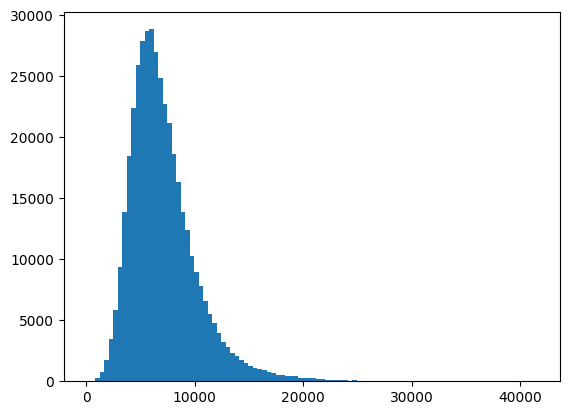

In [7]:
from xgboost import XGBRegressor
#? XGBRegressor it gives parameters you can aooly in this
model=XGBRegressor(random_state=42,n_jobs=-1,max_depth=4,n_estimators=20)
model.fit(x_train,target)

preds=model.predict(x_train)
#preds.tolist()



from sklearn.metrics import mean_squared_error
mse=mean_squared_error(preds,target)
rmse=mse**0.5   #here we have find out mean square then got its root so we got rmse
rmse


merged_df.Sales.max()
import matplotlib.pyplot as plt
plt.hist(merged_df.Sales,bins=100)  #bins describes no. of bars

<Axes: >

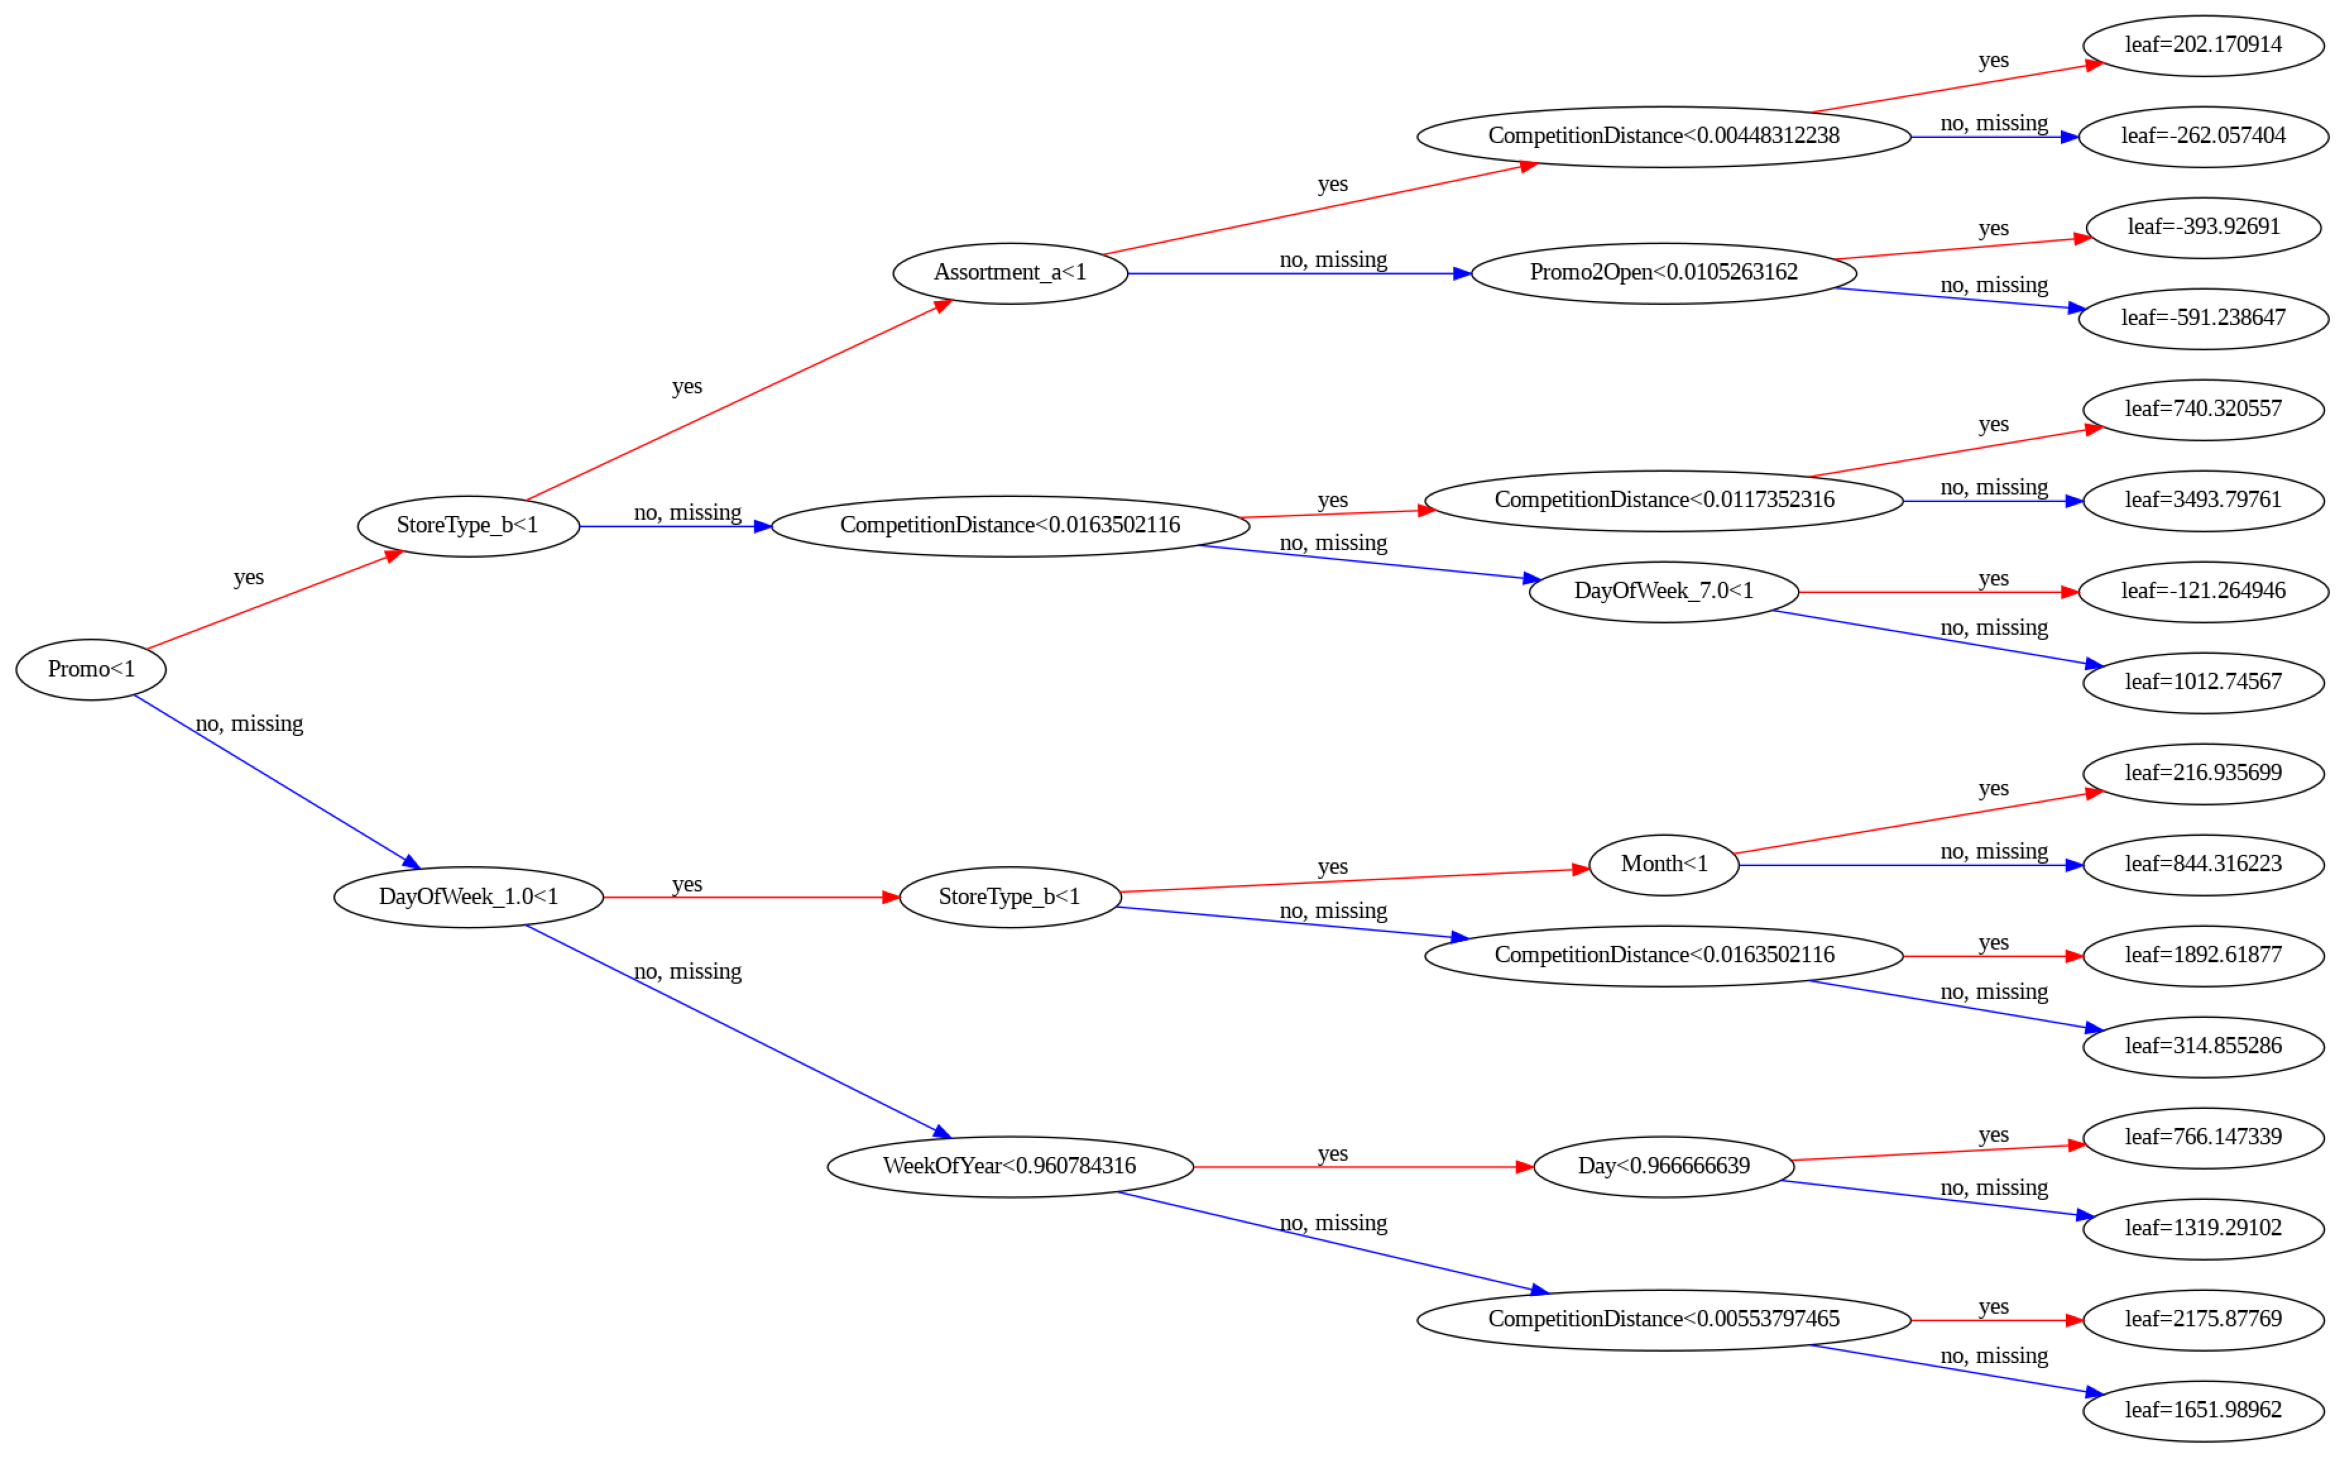

In [8]:
from xgboost import plot_tree
from matplotlib.pyplot import rcParams
rcParams["figure.figsize"]=30,30
plot_tree(model,num_trees=0,rankdir="LR") #it set the direction of the tree its from left to right

In [9]:
trees=model.get_booster().get_dump()   #it describes tree in text format
len(trees)
print(trees[0])


importance_df=pd.DataFrame({"features":x_train.columns,"importance":model.feature_importances_}).sort_values("importance",ascending=False)
importance_df   # here we have created a dataframe using a ductionary


0:[Promo<1] yes=1,no=2,missing=2
	1:[StoreType_b<1] yes=3,no=4,missing=4
		3:[Assortment_a<1] yes=7,no=8,missing=8
			7:[CompetitionDistance<0.00448312238] yes=15,no=16,missing=16
				15:leaf=202.170914
				16:leaf=-262.057404
			8:[Promo2Open<0.0105263162] yes=17,no=18,missing=18
				17:leaf=-393.92691
				18:leaf=-591.238647
		4:[CompetitionDistance<0.0163502116] yes=9,no=10,missing=10
			9:[CompetitionDistance<0.0117352316] yes=19,no=20,missing=20
				19:leaf=740.320557
				20:leaf=3493.79761
			10:[DayOfWeek_7.0<1] yes=21,no=22,missing=22
				21:leaf=-121.264946
				22:leaf=1012.74567
	2:[DayOfWeek_1.0<1] yes=5,no=6,missing=6
		5:[StoreType_b<1] yes=11,no=12,missing=12
			11:[Month<1] yes=23,no=24,missing=24
				23:leaf=216.935699
				24:leaf=844.316223
			12:[CompetitionDistance<0.0163502116] yes=25,no=26,missing=26
				25:leaf=1892.61877
				26:leaf=314.855286
		6:[WeekOfYear<0.960784316] yes=13,no=14,missing=14
			13:[Day<0.966666639] yes=27,no=28,missing=28
				27:leaf=766.1473

,features,importance
19,Promo,0.342387
11,DayOfWeek_1.0,0.103104
1,StoreType_b,0.073565
25,Promo2,0.059368
23,Promo2Open,0.043785
21,CompetitionDistance,0.042635
4,Assortment_a,0.038695
26,Day,0.038042
29,WeekOfYear,0.035647
27,Month,0.029806


In [10]:
from sklearn.model_selection import KFold
def train_evaluate (x_train,train_target,x_val,val_target,**params):
    model=XGBRegressor (random_state=42,n_jobs=-1,**params)
    model.fit(x_train,train_target)
    mse=mean_squared_error(model.predict(x_val),val_target)
    val_rmse=mse**0.5
    mse1=mean_squared_error(model.predict(x_train),train_target)
    train_rmse=mse1**0.5
    return train_rmse , val_rmse, model


kfold= KFold(n_splits=5)
models=[]
for train_idxs,val_idxs in kfold.split(x_train) :
  xtrain,xval=x_train.iloc[train_idxs],x_train.iloc[val_idxs]
  traintarget,valtarget=target.iloc[train_idxs],target.iloc[val_idxs]
  train_rmse,val_rmse,model=train_evaluate(xtrain,traintarget,xval,valtarget,max_depth=4,n_estimators=20)
  models.append(model)
  print("train rmse:{},val rmse:{}".format(train_rmse,val_rmse))


train rmse:2365.416348129859,val rmse:2411.858412096365
train rmse:2344.9153502845256,val rmse:2347.3045179524534
train rmse:2354.757099999913,val rmse:2874.587361692109
train rmse:2363.934220743039,val rmse:2232.946595868338
train rmse:2371.550336805019,val rmse:2449.2628482872146


In [11]:
model=XGBRegressor(n_jobs=-1,max_depth=4,n_estimators=50,random_state=42,learning_rate=0.2,sub_sample=0.9,colsample_bytree=0.2)
model.fit(x_train,target)
preds=model.predict(x_test)

preds.tolist()

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [16:33:20] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "sub_sample" } are not used.

  warnings.warn(smsg, UserWarning)


[7371.3544921875,
 6549.6875,
 9123.412109375,
 7136.45458984375,
 8224.7646484375,
 6881.2705078125,
 7442.25439453125,
 7544.94873046875,
 6129.11767578125,
 6615.26025390625,
 7486.50927734375,
 8142.70068359375,
 7339.7705078125,
 6689.892578125,
 7446.9755859375,
 6117.5869140625,
 7124.744140625,
 7178.79248046875,
 7895.8427734375,
 7745.43115234375,
 7741.26318359375,
 7420.658203125,
 7681.66455078125,
 6501.22021484375,
 8187.20361328125,
 7555.59033203125,
 7341.76904296875,
 7211.31689453125,
 7902.2021484375,
 7271.86572265625,
 7840.1240234375,
 9079.3466796875,
 6746.3623046875,
 7440.91552734375,
 6568.9228515625,
 8847.3974609375,
 6579.18359375,
 7860.615234375,
 7185.7314453125,
 7647.12744140625,
 7442.56640625,
 7218.30126953125,
 7238.72216796875,
 7317.8525390625,
 8739.2294921875,
 6947.703125,
 7358.22705078125,
 8303.826171875,
 6746.3623046875,
 8502.3828125,
 8872.1943359375,
 7146.5810546875,
 8277.40234375,
 6694.10009765625,
 6552.26806640625,
 8059.23291

In [17]:
test_df.Open.isna().sum()

#submission_df=pd.read_csv("/tmp/sample_submission.csv")

submission_df["Sales"]=preds
submission_df

submission_df["Sales"]=submission_df["Sales"]*test_df.Open.fillna(0)   #we have trained on model on open so for open==0 we multiplied it

submission_df.sample(20)


submission_df.to_csv("submission.csv",index=False)

NameError: name 'submission_df' is not defined